# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

## Dataset

Load, analyze, feature engineer and feature creation.

Apriori knowledge:
- 20 Years data, 2003-2022
- 2015 economic shift, with a steep upward trend on measures.
- 2020 blackswan event, breaking trend. Trends is realigned on 2021.
- Data is a timeseries, with monthly intervals.
- Data has a unit root, with a rising trend due to population, industry and climate increase.
- Data hasa seasonality with low demand at spring and autum, and highest demand end of summer.

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt


DATA_PATH = "./data"


END_DATE = datetime(2022, 12, 31)

train_df = pd.read_csv(f"{DATA_PATH}/train_data.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv(f"{DATA_PATH}/test_data.csv", index_col=0, parse_dates=True)
test_df = test_df[test_df.index <= END_DATE]


print(f"Shapes: train_df: {train_df.shape} test_df: {test_df.shape}")


test_df.head(12)

Shapes: train_df: (192, 10) test_df: (48, 10)


,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tmin,tavg,tmax
Date,,,,,,,,,,
2019-01-01,0.44,224.76,46.96,10.45,72.16,14.19,504.06,8.8,11.6,14.4
2019-02-01,0.43,199.54,60.59,11.93,64.06,14.19,504.06,8.7,12.0,15.3
2019-03-01,0.39,199.28,58.86,16.83,63.98,14.19,504.06,11.2,14.5,17.7
2019-04-01,0.36,186.04,44.68,17.85,59.73,14.19,504.06,12.6,15.9,19.1
2019-05-01,0.33,189.43,34.20,21.52,60.81,14.19,504.06,14.3,18.3,22.3
2019-06-01,0.45,231.40,45.46,22.85,74.29,14.19,504.06,21.3,26.3,31.4
2019-07-01,0.50,278.55,82.34,23.40,89.42,14.19,504.06,23.2,27.5,32.6
2019-08-01,0.48,283.84,69.46,21.64,91.12,14.19,504.06,23.8,28.2,32.5
2019-09-01,0.43,238.35,68.75,18.01,76.52,14.19,504.06,22.0,25.6,29.1


## Baseline Model

We know its a timeseries, seasonal and not stationary. Let's observe this in the data:

<Figure size 1200x600 with 0 Axes>

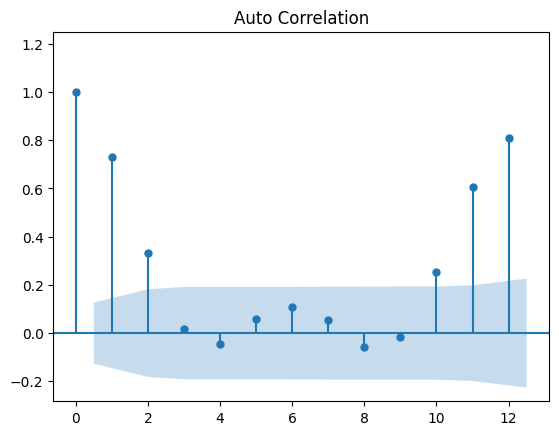

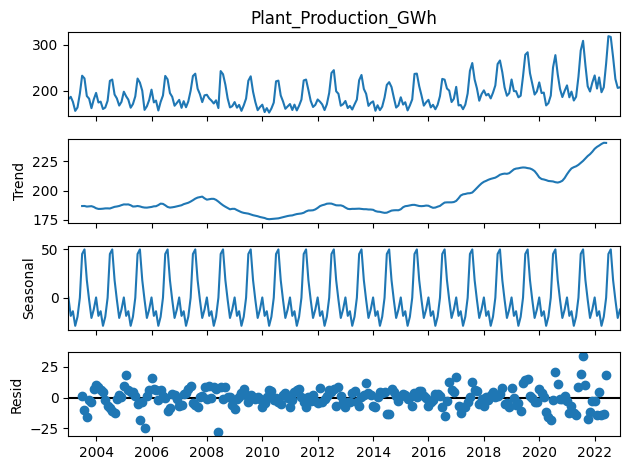

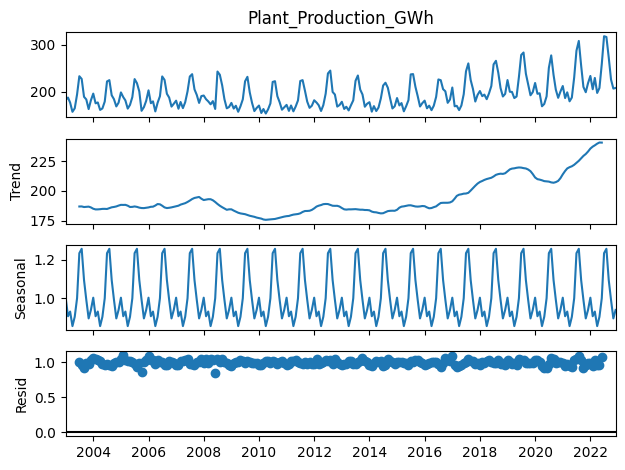

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

FEATURES = [
    "Population_k",
    "tmax",
    "GDP_bln",
    "Plant_Production_GWh",
]
TARGET = 
INDEX = "Date"
TIME_WINDOW = 1
LAGS = 1

data_ts = pd.concat([train_df[TARGET], test_df[TARGET]])

plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(
    data_ts,
    lags=LAGS * 12,
    auto_ylims=True,
    title="Auto Correlation",
)

a_season = seasonal_decompose(data_ts, model="a", period=12)
m_season = seasonal_decompose(data_ts, model="m", period=12)
fig = a_season.plot()
fig = m_season.plot()
plt.show()

First plot is ACF:
- There is significant autoregression at lag 1,2, 11,12 between a pearson of  6 o 8.

Second plots:
- Addition is noise, shows that there is no linear relation.
- Multiplicative is straightforward

Therefore it needs its  unitroot removed, and its seasonality wieghts extracted.
Doing this will produce a 'flat' timeseries below:

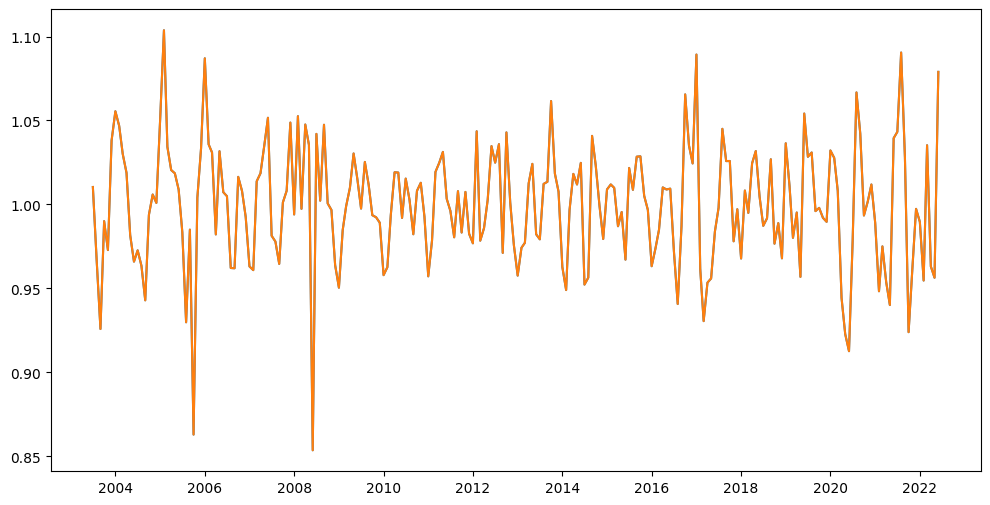

In [3]:
flat_target = data_ts.values / m_season.seasonal / m_season.trend

plt.figure(figsize=(12, 6))
plt.plot(data_ts.index, flat_target, flat_target)
plt.show()

Finally we verify test the Null Hypothesis (H0) that the data is not stationary, using an augmented Dickey–Fuller test (ADF). 

We see that the T statistic and P-valuue are positive and large, meaning H0 is not rejected and our data is not stationary and has a unit root.

In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_ts.values)
print("T-stat: %f" % result[0])
print("p-value: %f" % result[1])

T-stat: 0.694873
p-value: 0.989735


In [5]:
from statsmodels.tsa.vector_ar.vecm import select_order
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.arima import auto_arima

# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arima
train_df.index.names = [INDEX]
arima = Pipeline(
    [
        ("boxcox", BoxCoxEndogTransformer(lmbda=0)),
        (
            "arima",
            auto_arima(
                y=train_df[TARGET],
                d=TIME_WINDOW,  # Diffs
                stationary=False,  # Has a trend
                start_p=LAGS,  # Lag
                m=12,  # Monthly seasonality
                seasonal=True,
                maxiter=30,
                with_intercept=True,
                information_criterion="bic",
                scoring="mse",
                stepwise=True,
                error_action="ignore",
                trace=True,
            ),
        ),
    ]
)

arima.fit(train_df[TARGET])
fc, co_int = arima.predict(
    n_periods=12 * 4, return_conf_int=True, inverse_transform=True
)  # 4 Years

Performing stepwise search to minimize bic
 ARIMA(1,1,2)(1,0,1)[12] intercept   : BIC=1411.278, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=1709.548, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=1622.256, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=1704.298, Time=0.06 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : BIC=inf, Time=0.53 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : BIC=1406.674, Time=1.71 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : BIC=1421.794, Time=1.42 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : BIC=inf, Time=1.81 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : BIC=1407.206, Time=2.09 sec
 ARIMA(0,1,2)(2,0,1)[12] intercept   : BIC=inf, Time=1.54 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : BIC=1394.400, Time=1.45 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : BIC=1388.409, Time=0.70 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : BIC=i

RMSE: 17.18
SMAPE: 5.44%


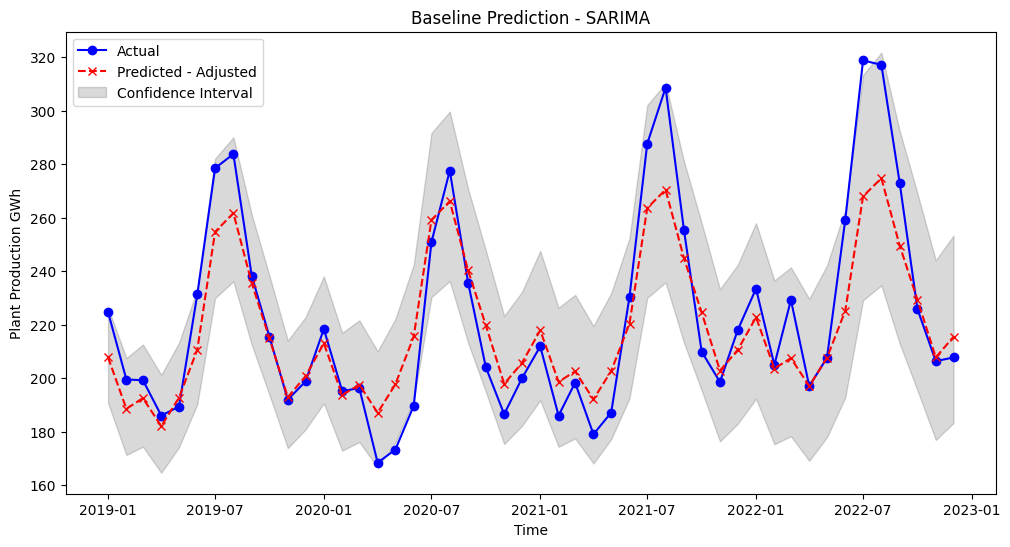

In [6]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

print(f"RMSE: {mean_squared_error(test_df[TARGET], fc, squared=False):0.02f}")
print(f"SMAPE: {smape(test_df[TARGET], fc):0.02f}%")

plt.figure(figsize=(12, 6))
plt.plot(test_df[TARGET], label="Actual", color="blue", marker="o")
plt.plot(
    test_df[TARGET].index,
    fc,
    label="Predicted - Adjusted",
    color="red",
    linestyle="dashed",
    marker="x",
)
plt.fill_between(
    test_df.index,
    co_int[:, 0],
    co_int[:, 1],
    color="k",
    alpha=0.15,
    label="Confidence Interval",
)

plt.xlabel("Time")
plt.ylabel("Plant Production GWh")
plt.title("Baseline Prediction - SARIMA")
plt.legend()
plt.show()

In [7]:
m_season_adjust = seasonal_decompose(train_df[TARGET], model="m", period=12)
df_adjustment = pd.DataFrame(
    {
        "Seasonal": m_season_adjust.seasonal,
        "Trend": m_season_adjust.trend,
        "Month": train_df.index.month,
    }
)

df_adjustment = df_adjustment.groupby("Month").mean()
df_adjustment.reset_index(inplace=True)

# Save weights for future prediction
df_adjustment.to_pickle(f"{DATA_PATH}/seasonal_adjustment.pkl")
df_adjustment

,Month,Seasonal,Trend
0,1,0.998435,186.890389
1,2,0.908536,187.069028
2,3,0.929513,187.320722
3,4,0.861764,187.532194
4,5,0.915589,187.675056
5,6,0.993432,187.788333
6,7,1.230321,186.227000
7,8,1.241180,186.288444
8,9,1.086606,186.344500
9,10,0.997740,186.467417


Givens:
- This is a multivariate TS of pop, temp, demand, industry signals.
- Assume these are asynchronous, therefore noisy

Data DIM:
- 0: Sequences
- 1: Data in sequence
- 2: Features for that datum (AKA channels for COV1D)

In [8]:
def encode_lagged_timeseries(data_df, window=TIME_WINDOW, lag=LAGS):
    sequences, features = list(), list()
    for i in range(window, 0, -1):
        sequences.append(data_df.shift(i))
        features += [("%s(t-%d)" % (col, i)) for col in data_df.columns]

    sequences.append(data_df)
    features += [("%s(t)" % (col)) for col in data_df.columns]

    # the target label - next month if lag is 1
    sequences.append(data_df.shift(-lag))
    features += [("%s(t+%d)" % (col, lag)) for col in data_df.columns]

    ts_df = pd.concat(sequences, axis=1)
    ts_df.columns = features
    ts_df.dropna(inplace=True)

    return ts_df


X = encode_lagged_timeseries(train_df[FEATURES])
y = encode_lagged_timeseries(train_df[[TARGET]])
Xt = encode_lagged_timeseries(test_df[FEATURES])
yt = encode_lagged_timeseries(test_df[[TARGET]])

print(f"Train -> X Shape: {X.shape} y Shape: {y.shape} ")
print(f"Testt -> X Shape: {Xt.shape} y Shape: {yt.shape} ")
X.head(2)

Train -> X Shape: (190, 9) y Shape: (190, 3) 
Testt -> X Shape: (46, 9) y Shape: (46, 3) 


,Population_k(t-1),tmax(t-1),GDP_bln(t-1),Population_k(t),tmax(t),GDP_bln(t),Population_k(t+1),tmax(t+1),GDP_bln(t+1)
Date,,,,,,,,,
2003-02-01,398.58,15.6,4.82,398.58,13.0,4.82,398.58,15.7,4.82
2003-03-01,398.58,13.0,4.82,398.58,15.7,4.82,398.58,18.7,4.82


In [9]:
X_series = X.values.reshape((X.shape[0], X.shape[1], 1))
Xt_series = Xt.values.reshape((Xt.shape[0], Xt.shape[1], 1))

y_series = y.values.reshape((y.shape[0], y.shape[1], 1))
yt_series = yt.values.reshape((yt.shape[0], yt.shape[1], 1))

print(f"Altered shapes: train: {X_series.shape} test: {Xt_series.shape}")

Altered shapes: train: (190, 9, 1) test: (46, 9, 1)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Input, MaxPooling1D, Dropout, Dense

EPOCHS = 95  # converges around here
BATCH_SIZE = 32
FILTERS = [128, 32, 12]
DROPRATE = 0.2
POOL_SIZE = 2
K_SIZE = 8

model = Sequential(
    [
        Input(shape=(X_series.shape[1], X_series.shape[2])),
        Conv1D(FILTERS[0], kernel_size=K_SIZE, activation="relu"),
        MaxPooling1D(pool_size=POOL_SIZE),  # DIM reduction by 2
        Flatten(),  # Vector dim reduction to 1
        Dense(60, activation="relu"),
        Dense(15, activation="relu"),
        Dropout(DROPRATE),  # this will lessen overfitting.
        Dense(1, activation="relu"),  # Next year 12 predictions.
    ]
)


model.compile(optimizer="adam", loss="mse", run_eagerly=True)
history = model.fit(
    X_series,
    y_series,
    validation_data=(Xt_series, yt_series),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 128)            1152      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 60)                7740      
                                                                 
 dense_1 (Dense)             (None, 15)                915       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                        

2/2 [==============================] - 0s 7ms/step
shapes: (190, 1) (190, 1)
RMSE train: 26.19
RMSE test: 40.03
SMAPE train: 10.15%
SMAPE test: 12.06%


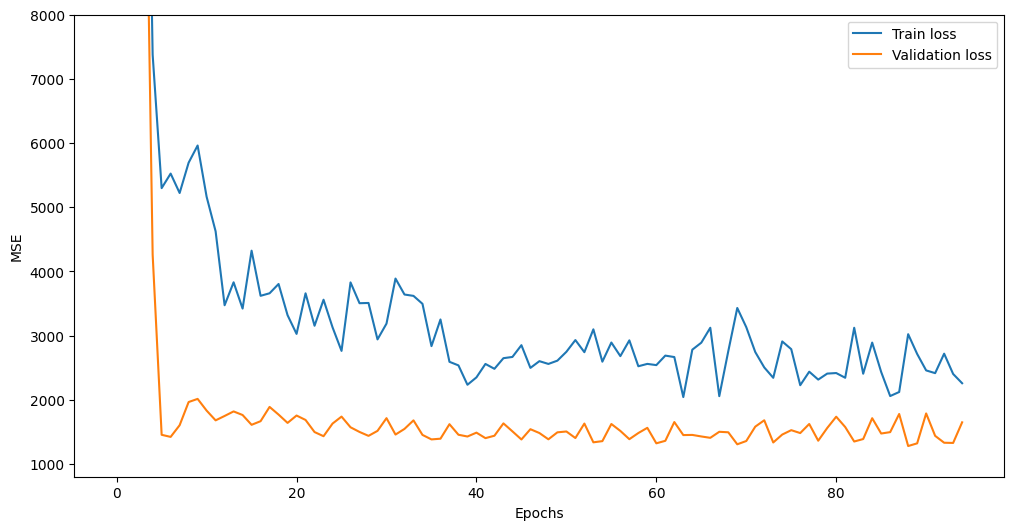

In [11]:
y_pred = model.predict(X_series)
yt_pred = model.predict(Xt_series)

y_pred_adjusted = np.copy(y_pred)
for i in range(len(y_pred_adjusted)):
    month = (i if i < 12 else i % 12) + 1
    y_pred_adjusted[i] *= df_adjustment[df_adjustment["Month"] == month][
        "Seasonal"
    ].values[0]
yt_pred_adjusted = np.copy(yt_pred)
for i in range(len(yt_pred_adjusted)):
    month = (i if i < 12 else i % 12) + 1
    yt_pred_adjusted[i] *= df_adjustment[df_adjustment["Month"] == month][
        "Seasonal"
    ].values[0]

print(f"shapes: {y_pred.shape} {y_pred.shape}")
print(
    f"RMSE train: {mean_squared_error(train_df[TARGET].iloc[LAGS:-LAGS], y_pred, squared=False):0.02f}"
)
print(
    f"RMSE test: {mean_squared_error(test_df[TARGET].iloc[LAGS:-LAGS], yt_pred, squared=False):0.02f}"
)
print(f"SMAPE train: {smape(train_df[TARGET].iloc[LAGS:-LAGS], y_pred):0.02f}%")
print(f"SMAPE test: {smape(test_df[TARGET].iloc[LAGS:-LAGS], yt_pred):0.02f}%")

plt.figure(figsize=(12, 6))
plt.ylim(bottom=800, top=8000)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()  # VGG16

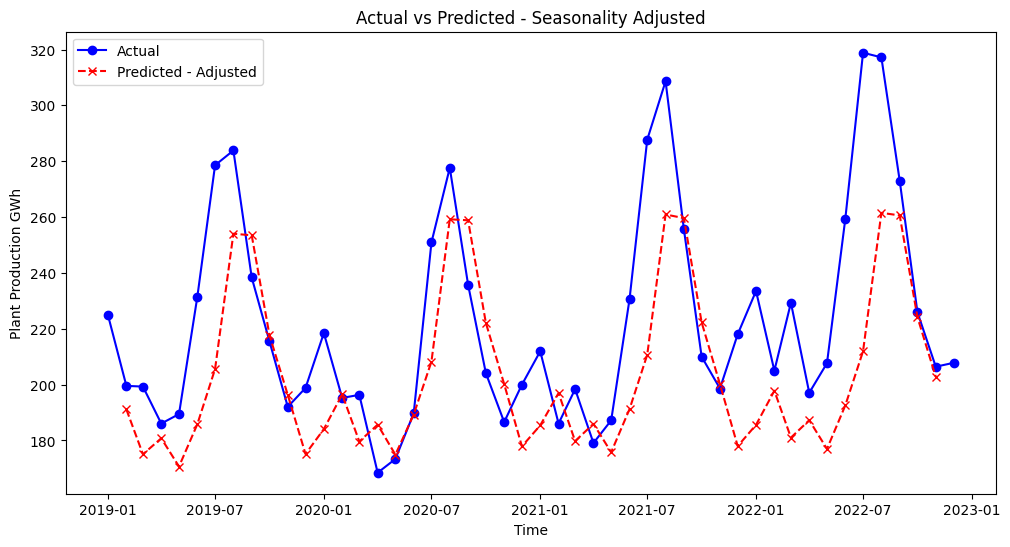

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(test_df[TARGET], label="Actual", color="blue", marker="o")
plt.plot(
    test_df[TARGET].iloc[TIME_WINDOW:-1].index,
    yt_pred_adjusted,
    label="Predicted - Adjusted",
    color="red",
    linestyle="dashed",
    marker="x",
)

plt.xlabel("Time")
plt.ylabel("Plant Production GWh")
plt.title("Actual vs Predicted - Seasonality Adjusted")
plt.legend()
plt.show()